# ODE Quick Overview

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import plotly.graph_objects as go
import pandas as pd


### Defining an ODE

In [2]:

def ratio_dydt(y,t):
    dydt = -2*y*t + 5
    return dydt


### Preparing Time Points + Zero Condition

In [10]:
y0 = 0
t = np.linspace(0,10,20)
t2 = np.linspace(0,10,200)

### Solving ODE

In [11]:
y_points = odeint(ratio_dydt, y0, t)
y_more_precise = odeint(ratio_dydt, y0, t2)

### Plotting

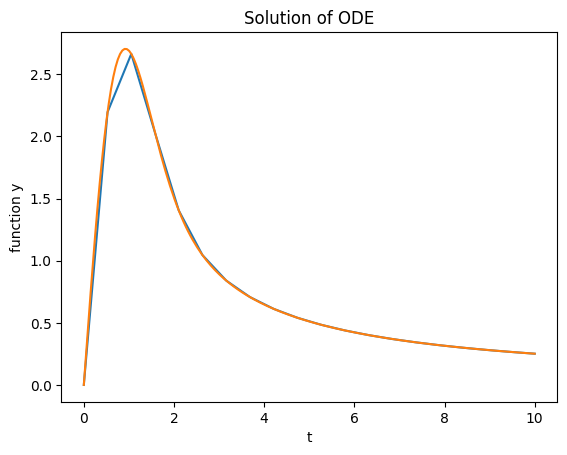

In [12]:
plt.plot(t, y_points, t2, y_more_precise)
plt.title("Solution of ODE")
plt.xlabel("t")
plt.ylabel("function y")
plt.show()

# Coupled Compartments

In [16]:
V_max = 3846
K_M = 874
k_e = 0.019

def ratio_dSdt(S,t):
    X_A, X_P = S
    absorption = V_max * X_A / (K_M + X_A)
    dXAdt = -absorption
    dXPdt = absorption - k_e * X_P
    return [dXAdt, dXPdt]

X_A_0 = 5000 # in milligrams
X_P_0 = 10 # baselines
S_0 = [X_A_0, X_P_0]

t = np.linspace(0,7,200)
solution = odeint(ratio_dSdt, y0=S_0, t=t)

X_P_sol = solution.T[1] # amount of creatine in plasma (mg)  
X_A_sol = solution.T[0] # amount of creatine in available in the gut (mg)  


### Gut and Plasma Creatine in [mg]

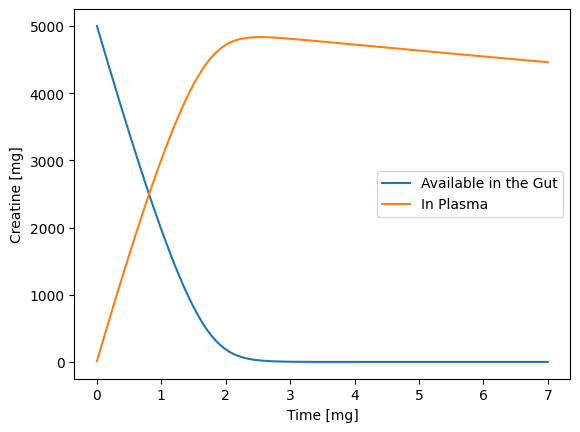

In [ ]:
plt.plot(t, X_A_sol, label='Available in the Gut')
plt.plot(t, X_P_sol, label='In Plasma')
plt.legend()
plt.xlabel('Time [h]')
plt.ylabel('Creatine [mg]')
plt.show()

### Plasma and Muscle Interstitial Concentration

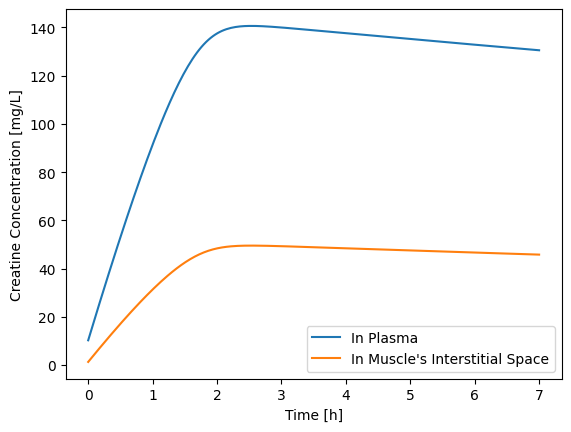

In [26]:
V_D = 37  # L
P_0 = 10   # baseline (mg/L)

C_P = X_P_sol / V_D + P_0 # plasma creatine concentration

F = 0.37 # penetration factor (no units; 0.37-0.47)
I0 = 1.2  # baseline interstitial creatine concentration mg/L
C_T = F * X_P_sol / V_D + I0 # muscle creatine concentration

plt.plot(t, C_P, label='In Plasma')
plt.plot(t, C_T, label='In Muscle\'s Interstitial Space')
plt.legend()
plt.xlabel('Time [h]')
plt.ylabel('Creatine Concentration [mg/L]')
plt.show()

### Including Muscle Compartment
Numerical starting guesses — maybe try, and then fit
- k_loss = 0.00072 h
- K_M_M ​= 100 mg/L (order-of-magnitude that brackets reported plasma concentrations)
- V_max_M = 500 mg/h (initial guess; gives ~12 g/day capacity if operating near Vmax — tune down/up)

Initial parameters, some of which could be later refined:

In [18]:
V_max = 3846       # mg/h (gut absorption)
K_M = 874          # mg
V_D = 37           # L
CL = 9.07          # L/h
k_e = CL / V_D     # h^-1 ≈ 0.25

V_max_M = 500      # mg/h (muscle uptake) REFINE!
K_M_M = 100        # mg/L (muscle MM constant) REFINE!
k_loss = 0.00096   # h^-1 (≈40-day half-life) REFINE!

t_half_creatine_indays = 30
k_loss = np.log(2) / (t_half_creatine_indays*24)  # 1/h, okolo 0.00096

### Initial conditions:

In [24]:
X_A_0 = 5000   # mg, one 5g oral dose
X_P_0 = 1000      # mg in plasma
X_M_0 = 0      # mg in muscle
S_0 = [X_A_0, X_P_0, X_M_0]

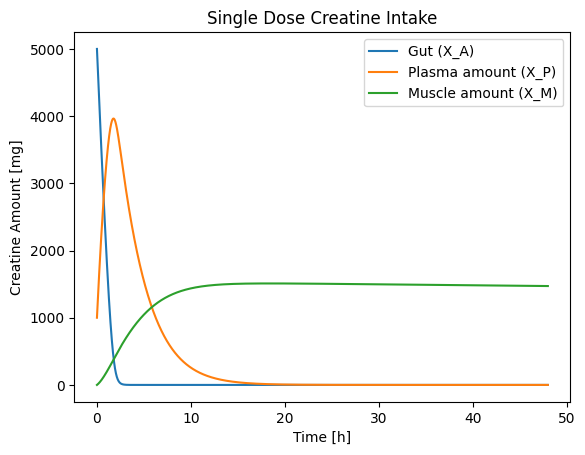

In [17]:
def creatine_model(S,t):
    X_A, X_P, X_M = S
    C_P = X_P / V_D  # mg/L
    absorption = V_max * X_A / (K_M + X_A)
    muscle_uptake = (V_max_M * C_P)/(K_M_M + C_P)
    dXAdt = - absorption
    dXPdt = absorption - k_e * X_P - muscle_uptake
    dXMdt = muscle_uptake - k_loss * X_M
    return [dXAdt, dXPdt, dXMdt]

S_0 = [X_A_0, X_P_0, X_M_0]

t = np.linspace(0,48,2000)
solution = odeint(creatine_model, y0=S_0, t=t)
X_A_sol, X_P_sol, X_M_sol = solution.T

plt.title('Single Dose Creatine Intake')
plt.plot(t, X_A_sol, label='Gut (X_A)')
plt.plot(t, X_P_sol, label='Plasma amount (X_P)')
plt.plot(t, X_M_sol, label='Muscle amount (X_M)')
plt.legend()
plt.xlabel('Time [h]')
plt.ylabel('Creatine Amount [mg]')
plt.show()

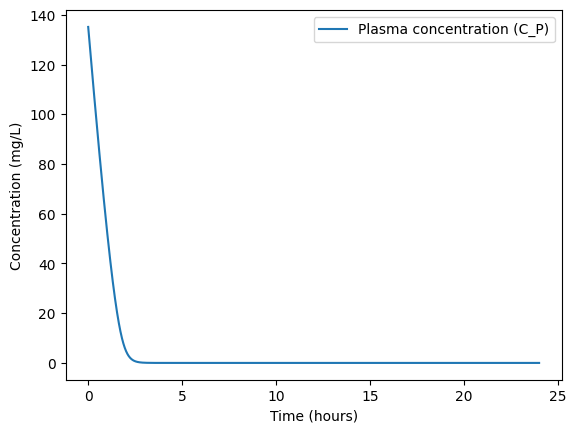

In [9]:
C_P = X_P_sol / V_D  # plasma concentration (mg/L)
plt.plot(t, C_P, label='Plasma concentration (C_P)')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (mg/L)')
plt.legend()
plt.show()

### Multiple Doses

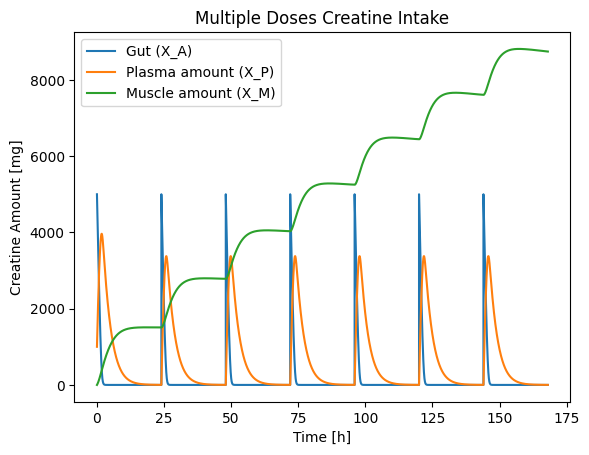

In [27]:
dose = 5000 # mg

def creatine_model(S,t):
    X_A, X_P, X_M = S
    C_P = X_P / V_D  # mg/L
    absorption = V_max * X_A / (K_M + X_A)
    muscle_uptake = (V_max_M * C_P)/(K_M_M + C_P)
    dXAdt = - absorption
    dXPdt = absorption - k_e * X_P - muscle_uptake
    dXMdt = muscle_uptake - k_loss * X_M
    return [dXAdt, dXPdt, dXMdt]

# Dose every 24h, 1000 steps in that time interval, we have 7 time intervals (7 days)

intervals = range(1,8)
concatenated_solution = []
concatenated_time = []

for interval in intervals:
    t = np.linspace((interval-1)*24, interval*24, 1000)
    if interval == 1:
        S_0 = [X_A_0, X_P_0, X_M_0]
    else:
        S_0 = [X_A_current[-1] + dose, X_P_current[-1], X_M_current[-1]]
    solution = odeint(creatine_model, y0=S_0, t=t)
    X_A_current, X_P_current, X_M_current = solution.T

    concatenated_time += list(t)
    concatenated_solution += list(zip(X_A_current, X_P_current, X_M_current))

concatenated_time = np.array(concatenated_time)
concatenated_solution = np.array(concatenated_solution)
X_A_sol, X_P_sol, X_M_sol = concatenated_solution.T

plt.title('Multiple Doses Creatine Intake')
plt.plot(concatenated_time, X_A_sol, label='Gut (X_A)')
plt.plot(concatenated_time, X_P_sol, label='Plasma amount (X_P)')
plt.plot(concatenated_time, X_M_sol, label='Muscle amount (X_M)')
plt.legend()
plt.xlabel('Time [h]')
plt.ylabel('Creatine Amount [mg]')
plt.show()